# Training

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import transforms
from PIL import Image, ImageFilter
import os
from tqdm import tqdm
import numpy as np
import random

# Define a function for applying thresholding to images
def apply_threshold(image, method='adaptive', block_size=10, C=2):
    """Apply thresholding to the image using Pillow."""
    image = np.array(image)  # Convert PIL Image to NumPy array

    if method == 'global':
        # Global thresholding
        thresh_image = np.where(image > 128, 255, 0)
    elif method == 'adaptive':
        # Adaptive thresholding (simplified version)
        from scipy.ndimage import uniform_filter
        local_mean = uniform_filter(image, size=block_size)
        thresh_image = np.where(image > (local_mean - C), 255, 0)
    else:
        raise ValueError("Invalid method. Use 'global' or 'adaptive'.")

    return Image.fromarray(thresh_image.astype(np.uint8))  # Convert back to PIL Image

# Preprocess function for random augmentation and thresholding
def preprocess_image(image):
    # Ensure the image is in grayscale (it should be after the Dataset step, but added here just in case)
    image = image.convert('L')
    
    # Apply adaptive thresholding
    image = apply_threshold(image, method='adaptive', block_size=11, C=2)
    
    # Convert image to numpy array for manipulation
    pixels = np.array(image, dtype=np.int32)  # Use int32 to prevent overflow issues

    return image 

# Dataset class for loading images and annotations
class DigitDataset(Dataset):
    def __init__(self, img_dir, label_dir, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_files = [f for f in os.listdir(img_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_files[idx])
        label_path = os.path.join(self.label_dir, self.img_files[idx].replace('.jpg', '.txt'))
        
        image = Image.open(img_path).convert('L')  # Convert to grayscale explicitly
        orig_width, orig_height = image.size
        
        if self.transform:
            image = self.transform(image)

        boxes = []
        labels = []
        
        with open(label_path, 'r') as f:
            lines = f.readlines()
            # Sort lines based on x-coordinate to maintain left-to-right order
            lines.sort(key=lambda x: float(x.strip().split()[1]))
            
            for line in lines:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                
                # Convert YOLO format to pixel coordinates
                x1 = (x_center - width/2) * orig_width
                y1 = (y_center - height/2) * orig_height
                x2 = (x_center + width/2) * orig_width
                y2 = (y_center + height/2) * orig_height
                
                # Ensure positive width and height
                if x2 > x1 and y2 > y1:
                    boxes.append([x1, y1, x2, y2])
                    labels.append(class_id)

        # Handle empty boxes
        if len(boxes) == 0:
            boxes.append([0, 0, orig_width/10, orig_height/10])
            labels.append(0)

        target = {}
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))

# Training setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Define transforms with custom preprocessing
transform = transforms.Compose([
    transforms.Resize((600, 600)),  # Smaller size to prevent memory issues
    transforms.Lambda(lambda x: preprocess_image(x)),  # Apply custom preprocessing
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Create datasets
train_dataset = DigitDataset('../final-project-code-report-1-cos-c/Clean Training Dataset/Training Images', 
                           '../final-project-code-report-1-cos-c/Clean Training Dataset/Training Coordinates', 
                           transform=transform)
train_loader = DataLoader(train_dataset, 
                         batch_size=8,  # Increased batch size
                         shuffle=True, 
                         collate_fn=collate_fn,
                         num_workers=2)  # Reduced workers

# Initialize model
num_classes = 10  # digits 0-9
model = fasterrcnn_resnet50_fpn(weights='DEFAULT')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)  # Changed to AdamW with lower learning rate
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

# Training loop
num_epochs = 40
best_loss = float('inf')

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
    
    for batch_idx, (images, targets) in enumerate(progress_bar):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        losses.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Added gradient clipping
        optimizer.step()

        running_loss += losses.item()
        current_loss = running_loss / (batch_idx + 1)
        progress_bar.set_postfix({
            'Loss': f'{current_loss:.4f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })

    epoch_loss = running_loss / len(train_loader)
    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Average Loss: {epoch_loss:.4f}")
    print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")
    
    scheduler.step(epoch_loss)

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_loss,
        }, 'best_digit_detection_model_dummy.pth')

print("\nTraining completed!")

Using device: cuda
Starting training...


Epoch 1/40: 100%|██████████| 489/489 [01:34<00:00,  5.15it/s, Loss=0.4348, LR=0.000100]



Epoch 1/40
Average Loss: 0.4348
Learning Rate: 0.000100


Epoch 2/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.3306, LR=0.000100]



Epoch 2/40
Average Loss: 0.3306
Learning Rate: 0.000100


Epoch 3/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.2992, LR=0.000100]



Epoch 3/40
Average Loss: 0.2992
Learning Rate: 0.000100


Epoch 4/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.2703, LR=0.000100]



Epoch 4/40
Average Loss: 0.2703
Learning Rate: 0.000100


Epoch 5/40: 100%|██████████| 489/489 [01:34<00:00,  5.18it/s, Loss=0.2489, LR=0.000100]



Epoch 5/40
Average Loss: 0.2489
Learning Rate: 0.000100


Epoch 6/40: 100%|██████████| 489/489 [01:33<00:00,  5.21it/s, Loss=0.2271, LR=0.000100]



Epoch 6/40
Average Loss: 0.2271
Learning Rate: 0.000100


Epoch 7/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.2130, LR=0.000100]



Epoch 7/40
Average Loss: 0.2130
Learning Rate: 0.000100


Epoch 8/40: 100%|██████████| 489/489 [01:33<00:00,  5.21it/s, Loss=0.1940, LR=0.000100]



Epoch 8/40
Average Loss: 0.1940
Learning Rate: 0.000100


Epoch 9/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.1818, LR=0.000100]



Epoch 9/40
Average Loss: 0.1818
Learning Rate: 0.000100


Epoch 10/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.1672, LR=0.000100]



Epoch 10/40
Average Loss: 0.1672
Learning Rate: 0.000100


Epoch 11/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.1567, LR=0.000100]



Epoch 11/40
Average Loss: 0.1567
Learning Rate: 0.000100


Epoch 12/40: 100%|██████████| 489/489 [01:33<00:00,  5.21it/s, Loss=0.1435, LR=0.000100]



Epoch 12/40
Average Loss: 0.1435
Learning Rate: 0.000100


Epoch 13/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.1339, LR=0.000100]



Epoch 13/40
Average Loss: 0.1339
Learning Rate: 0.000100


Epoch 14/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.1254, LR=0.000100]



Epoch 14/40
Average Loss: 0.1254
Learning Rate: 0.000100


Epoch 15/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.1151, LR=0.000100]



Epoch 15/40
Average Loss: 0.1151
Learning Rate: 0.000100


Epoch 16/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.1092, LR=0.000100]



Epoch 16/40
Average Loss: 0.1092
Learning Rate: 0.000100


Epoch 17/40: 100%|██████████| 489/489 [01:33<00:00,  5.24it/s, Loss=0.1027, LR=0.000100]



Epoch 17/40
Average Loss: 0.1027
Learning Rate: 0.000100


Epoch 18/40: 100%|██████████| 489/489 [01:33<00:00,  5.24it/s, Loss=0.0960, LR=0.000100]



Epoch 18/40
Average Loss: 0.0960
Learning Rate: 0.000100


Epoch 19/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.0934, LR=0.000100]



Epoch 19/40
Average Loss: 0.0934
Learning Rate: 0.000100


Epoch 20/40: 100%|██████████| 489/489 [01:33<00:00,  5.21it/s, Loss=0.0896, LR=0.000100]



Epoch 20/40
Average Loss: 0.0896
Learning Rate: 0.000100


Epoch 21/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0846, LR=0.000100]



Epoch 21/40
Average Loss: 0.0846
Learning Rate: 0.000100


Epoch 22/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.0825, LR=0.000100]



Epoch 22/40
Average Loss: 0.0825
Learning Rate: 0.000100


Epoch 23/40: 100%|██████████| 489/489 [01:34<00:00,  5.16it/s, Loss=0.0787, LR=0.000100]



Epoch 23/40
Average Loss: 0.0787
Learning Rate: 0.000100


Epoch 24/40: 100%|██████████| 489/489 [01:37<00:00,  5.03it/s, Loss=0.0768, LR=0.000100]



Epoch 24/40
Average Loss: 0.0768
Learning Rate: 0.000100


Epoch 25/40: 100%|██████████| 489/489 [01:36<00:00,  5.07it/s, Loss=0.0736, LR=0.000100]



Epoch 25/40
Average Loss: 0.0736
Learning Rate: 0.000100


Epoch 26/40: 100%|██████████| 489/489 [01:34<00:00,  5.16it/s, Loss=0.0699, LR=0.000100]



Epoch 26/40
Average Loss: 0.0699
Learning Rate: 0.000100


Epoch 27/40: 100%|██████████| 489/489 [01:34<00:00,  5.20it/s, Loss=0.0676, LR=0.000100]



Epoch 27/40
Average Loss: 0.0676
Learning Rate: 0.000100


Epoch 28/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.0655, LR=0.000100]



Epoch 28/40
Average Loss: 0.0655
Learning Rate: 0.000100


Epoch 29/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0646, LR=0.000100]



Epoch 29/40
Average Loss: 0.0646
Learning Rate: 0.000100


Epoch 30/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0613, LR=0.000100]



Epoch 30/40
Average Loss: 0.0613
Learning Rate: 0.000100


Epoch 31/40: 100%|██████████| 489/489 [01:33<00:00,  5.21it/s, Loss=0.0619, LR=0.000100]



Epoch 31/40
Average Loss: 0.0619
Learning Rate: 0.000100


Epoch 32/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0610, LR=0.000100]



Epoch 32/40
Average Loss: 0.0610
Learning Rate: 0.000100


Epoch 33/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.0584, LR=0.000100]



Epoch 33/40
Average Loss: 0.0584
Learning Rate: 0.000100


Epoch 34/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0579, LR=0.000100]



Epoch 34/40
Average Loss: 0.0579
Learning Rate: 0.000100


Epoch 35/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0541, LR=0.000100]



Epoch 35/40
Average Loss: 0.0541
Learning Rate: 0.000100


Epoch 36/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.0524, LR=0.000100]



Epoch 36/40
Average Loss: 0.0524
Learning Rate: 0.000100


Epoch 37/40: 100%|██████████| 489/489 [01:33<00:00,  5.22it/s, Loss=0.0540, LR=0.000100]



Epoch 37/40
Average Loss: 0.0540
Learning Rate: 0.000100


Epoch 38/40: 100%|██████████| 489/489 [01:33<00:00,  5.21it/s, Loss=0.0523, LR=0.000100]



Epoch 38/40
Average Loss: 0.0523
Learning Rate: 0.000100


Epoch 39/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0502, LR=0.000100]



Epoch 39/40
Average Loss: 0.0502
Learning Rate: 0.000100


Epoch 40/40: 100%|██████████| 489/489 [01:33<00:00,  5.23it/s, Loss=0.0517, LR=0.000100]


Epoch 40/40
Average Loss: 0.0517
Learning Rate: 0.000100

Training completed!


# Testing

In [16]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import transforms
from torchmetrics.detection.mean_ap import MeanAveragePrecision
from PIL import Image, ImageFilter
import os
from tqdm import tqdm
import numpy as np
import random


def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) between two boxes"""
    # Get coordinates of intersection rectangle
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Calculate area of intersection
    intersection = max(0, x2 - x1) * max(0, y2 - y1)
    
    # Calculate area of both boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    
    # Calculate union area
    union = box1_area + box2_area - intersection
    
    # Return IoU
    return intersection / union if union > 0 else 0

def apply_threshold(image, method='adaptive', block_size=10, C=2):
    """Apply thresholding to the image using Pillow."""
    image = np.array(image)  # Convert PIL Image to NumPy array

    if method == 'global':
        # Global thresholding
        thresh_image = np.where(image > 128, 255, 0)
    elif method == 'adaptive':
        # Adaptive thresholding (simplified version)
        from scipy.ndimage import uniform_filter
        local_mean = uniform_filter(image, size=block_size)
        thresh_image = np.where(image > (local_mean - C), 255, 0)
    else:
        raise ValueError("Invalid method. Use 'global' or 'adaptive'.")

    return Image.fromarray(thresh_image.astype(np.uint8))  # Convert back to PIL Image

def preprocess_image(image):
    """Custom preprocessing: Thresholding, blurring, and pixel value adjustment"""
    # Apply adaptive thresholding
    image = apply_threshold(image, method='adaptive', block_size=10, C=2)

    # Convert image to numpy array for manipulation
    pixels = np.array(image, dtype=np.int32)  # Use int32 to prevent overflow issues

    return image

class ThresholdTransform:
    def init(self, method='adaptive', block_size=10, C=2):
        self.method = method
        self.block_size = block_size
        self.C = C

    def call(self, img):
        return apply_threshold(img, self.method, self.block_size, self.C)

def load_model(model_path, device):
    # Load the state dict
    checkpoint = torch.load(model_path, map_location=device)
    state_dict = checkpoint['model_state_dict']
    
    # Determine the number of classes from the state dict
    num_classes = state_dict['roi_heads.box_predictor.cls_score.weight'].size(0)
    
    # Initialize the model with the correct number of classes
    model = fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # Load the state dict
    model.load_state_dict(state_dict)
    model.to(device)
    model.eval()
    return model

def evaluate_test_set(model_path, test_images_dir, test_labels_dir, confidence_threshold=0.5, unknown_threshold=0.3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_model(model_path, device)
    
    transform = transforms.Compose([
        transforms.Lambda(lambda x: preprocess_image(x)),
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    test_images = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
    
    # Initialize MeanAveragePrecision metric
    map_metric = MeanAveragePrecision(box_format="xyxy", iou_type="bbox")
    
    all_ious = []
    correct_predictions = 0
    total_ground_truths = 0
    total_predictions = 0
    unknown_predictions = 0
    
    for image_name in tqdm(test_images, desc="Evaluating Test Images"):
        image_path = os.path.join(test_images_dir, image_name)
        label_path = os.path.join(test_labels_dir, image_name.replace('.jpg', '.txt'))
        
        image = Image.open(image_path).convert('L')
        orig_size = image.size
        image_tensor = transform(image).unsqueeze(0).to(device)
        
        with torch.no_grad():
            predictions = model(image_tensor)[0]
        
        with open(label_path, 'r') as f:
            gt_data = [line.strip().split() for line in f.readlines()]
            
        gt_boxes = []
        gt_labels = []
        for line in gt_data:
            label = int(line[0])
            x_center, y_center, width, height = map(float, line[1:])
            
            x1 = (x_center - width/2) * orig_size[0]
            y1 = (y_center - height/2) * orig_size[1]
            x2 = (x_center + width/2) * orig_size[0]
            y2 = (y_center + height/2) * orig_size[1]
            
            gt_boxes.append([x1, y1, x2, y2])
            gt_labels.append(label)
        
        total_ground_truths += len(gt_boxes)
        
        pred_boxes = predictions['boxes'].cpu()
        pred_scores = predictions['scores'].cpu()
        pred_labels = predictions['labels'].cpu()
        
        # Filter predictions based on confidence threshold and identify unknown objects
        unknown_mask = pred_scores < unknown_threshold
        known_mask = pred_scores >= confidence_threshold
        
        unknown_boxes = pred_boxes[unknown_mask]
        unknown_scores = pred_scores[unknown_mask]
        unknown_labels = torch.full((unknown_scores.size(0),), -1, dtype=torch.int64)
        
        pred_boxes = pred_boxes[known_mask]
        pred_scores = pred_scores[known_mask]
        pred_labels = pred_labels[known_mask]
        
        # Combine known and unknown predictions
        pred_boxes = torch.cat([pred_boxes, unknown_boxes])
        pred_scores = torch.cat([pred_scores, unknown_scores])
        pred_labels = torch.cat([pred_labels, unknown_labels])
        
        total_predictions += len(pred_boxes)
        unknown_predictions += len(unknown_boxes)
        
        # Update MeanAveragePrecision metric
        map_metric.update([{
            'boxes': pred_boxes,
            'scores': pred_scores,
            'labels': pred_labels
        }], [{
            'boxes': torch.tensor(gt_boxes),
            'labels': torch.tensor(gt_labels)
        }])
        
        # Calculate IoU and correct predictions
        for pred_box, pred_label in zip(pred_boxes, pred_labels):
            for gt_box, gt_label in zip(gt_boxes, gt_labels):
                if gt_label == pred_label or (gt_label == -1 and pred_label == -1):
                    iou = calculate_iou(pred_box, gt_box)
                    all_ious.append(iou)
                    if iou > 0.5:  # You can adjust this threshold as needed
                        correct_predictions += 1
                    break  # Move to the next prediction after finding a match
    
    # Compute final metrics
    map_results = map_metric.compute()
    avg_iou = np.mean(all_ious) if all_ious else 0
    accuracy = correct_predictions / total_ground_truths if total_ground_truths > 0 else 0
    
    # Print results
    print(f'Mean Average Precision (mAP): {map_results["map"]:.3f}')
    print(f'Average Precision (AP) @ IoU=0.50: {map_results["map_50"]:.3f}')
    print(f'Average Precision (AP) @ IoU=0.75: {map_results["map_75"]:.3f}')
    print(f'Average IoU across all test images: {avg_iou:.3f}')
    print(f'Number of valid detections: {len(all_ious)}')
    print(f'Accuracy of class predictions (w.r.t. ground truth): {accuracy:.3f}')
    print(f'Total ground truth objects: {total_ground_truths}')
    print(f'Total predictions: {total_predictions}')
    print(f'Correct predictions: {correct_predictions}')
    print(f'Unknown predictions: {unknown_predictions}')
    
    return map_results, avg_iou, accuracy

model_path = 'best_digit_detection_model.pth'
test_images_dir = 'test_images_dir_path'
test_labels_dir = 'test_labels_dir_path'
overall_iou = evaluate_test_set(model_path, test_images_dir, test_labels_dir)

model_path = 'best_digit_detection_model.pth'
test_images_dir = 'test_images_dir_path2'
test_labels_dir = 'test_labels_dir_path2'
overall_iou = evaluate_test_set(model_path, test_images_dir, test_labels_dir)

/scratch/local/51842068/ipykernel_1477672/2579809681.py:73: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)
Evaluating

Mean Average Precision (mAP): 0.598
Average Precision (AP) @ IoU=0.50: 0.764
Average Precision (AP) @ IoU=0.75: 0.727
Average IoU across all test images: 0.813
Number of valid detections: 7050
Accuracy of class predictions (w.r.t. ground truth): 0.730
Total ground truth objects: 8840
Total predictions: 8834
Correct predictions: 6457
Unknown predictions: 1282


Evaluating Test Images: 100%|██████████| 200/200 [00:05<00:00, 35.18it/s]


Mean Average Precision (mAP): 0.538
Average Precision (AP) @ IoU=0.50: 0.747
Average Precision (AP) @ IoU=0.75: 0.616
Average IoU across all test images: 0.765
Number of valid detections: 347
Accuracy of class predictions (w.r.t. ground truth): 0.737
Total ground truth objects: 418
Total predictions: 483
Correct predictions: 308
Unknown predictions: 93


# Visualisation

/scratch/local/51842068/ipykernel_1477672/599012430.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path, map_location=device)


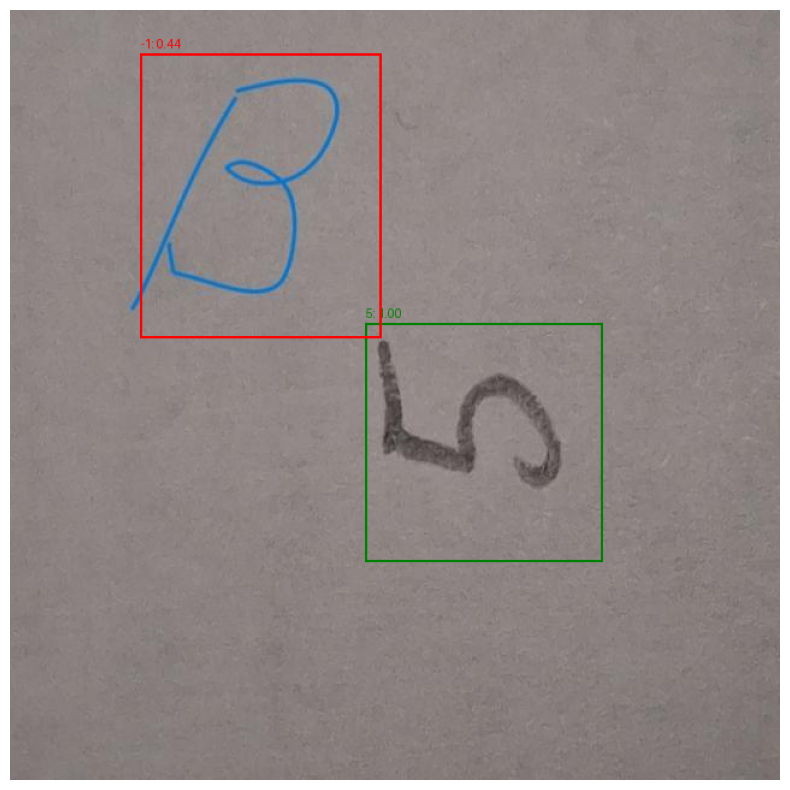

In [20]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision import transforms
from PIL import Image, ImageDraw, ImageFont

def load_model(model_path, device):
    num_classes = 10  # Keep this as 10, we'll handle the -1 class separately
    model = fasterrcnn_resnet50_fpn(weights=None)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    return model

def predict_and_visualize(model_path, image_path, confidence_threshold=0.5, unknown_threshold=0.3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = load_model(model_path, device)
    
    transform = transforms.Compose([
        transforms.Resize((600, 600)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    try:
        # Load and process image
        pil_image = Image.open(image_path).convert('L')
        orig_size = pil_image.size
        image_tensor = transform(pil_image).unsqueeze(0).to(device)
        
        # Get predictions
        with torch.no_grad():
            predictions = model(image_tensor)[0]
        
        # Load original image for visualization
        display_image = Image.open(image_path).convert('RGB')
        draw = ImageDraw.Draw(display_image)
        
        # Get prediction data
        boxes = predictions['boxes'].cpu().numpy()
        labels = predictions['labels'].cpu().numpy()
        scores = predictions['scores'].cpu().numpy()
        
        # Calculate scaling factors
        scale_x = orig_size[0] / 600
        scale_y = orig_size[1] / 600
        
        # Draw predictions
        for box, label, score in zip(boxes, labels, scores):
            if score > unknown_threshold:
                # Scale box coordinates
                x1, y1, x2, y2 = box
                x1, x2 = x1 * scale_x, x2 * scale_x
                y1, y2 = y1 * scale_y, y2 * scale_y
                
                # Determine color and label based on confidence
                if score > confidence_threshold:
                    color = 'green'
                    label_text = f'{label}: {score:.2f}'
                else:
                    color = 'red'
                    label_text = f'-1: {score:.2f}'
                
                # Draw rectangle
                draw.rectangle([(x1, y1), (x2, y2)], 
                             outline=color, 
                             width=2)
                
                # Draw label
                draw.text((x1, y1-15), 
                         label_text,
                         fill=color)
        
        # Display using matplotlib
        plt.figure(figsize=(10, 10))
        plt.imshow(display_image)
        plt.axis('off')
        plt.show()
        
    except Exception as e:
        print(f"Error processing image: {str(e)}")

if __name__ == '__main__':
    model_path = 'best_digit_detection_model.pth'
    image_path = 'test_images_path'
    predict_and_visualize(model_path, image_path, confidence_threshold=0.5, unknown_threshold=0.3)